In [52]:
#1.Analyze the distribution of **tenure** (number of months under contract) in relation to customer churn. 
#Churn Analysis in Telco
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import numpy as np

#load the dataset
file_path= "D:/PWC-DS/client_data/Churn.csv"
churn_data= pd.read_csv(file_path)
churn_data.head()


CustomerID  Gender  SeniorCitizen Partner Dependents  Tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [53]:
#1. Analyze the distribution of **tenure** (number of months under contract) in relation to customer churn.
sns.set(style="whitegrid")
# Plotting the distribution of tenure in relation to customer churn

plt.figure(figsize=(10,6))
sns.histplot(data=churn_data, x='Tenure', hue='Churn', kde=True, bins=30, palette='viridis')
plt.title('Distribution of Tenure in Relation to Customer Churn')
plt.xlabel('Tenure(Months)')
plt.ylabel('Number of Customers')
plt.legend(title='Churn', labels=['No', 'Yes'])
plt.show()

In [54]:
#2. 
#Calculate the **Average Monthly Revenue per User (ARPU)** by contract type.
avg_arpu_by_contract = churn_data.groupby('Contract')['MonthlyCharges'].mean().reset_index()

avg_arpu_by_contract.rename(columns={'MonthlyCharges': 'Average ARPU'}, inplace=True)

print(avg_arpu_by_contract)


         Contract  Average ARPU
0  Month-to-month     66.398490
1        One year     65.048608
2        Two year     60.770413


In [55]:
#2. 
#Calculate the **Average Monthly Revenue per User (ARPU)** by tenure.
# Define tenure bins -by using a bin size of 12 months to group customers annually
churn_data['TenureGroup'] = pd.cut(churn_data['Tenure'], bins=[0, 12, 24, 36, 48, 60, 72], labels=['0-12', '13-24', '25-36', '37-48', '49-60', '61-72'])

avg_arpu_by_tenure = churn_data.groupby(['TenureGroup'])['MonthlyCharges'].mean().reset_index()

avg_arpu_by_tenure.rename(columns={'MonthlyCharges': 'Average ARPU'}, inplace=True)

print(avg_arpu_by_tenure)

  TenureGroup  Average ARPU
0        0-12     56.172023
1       13-24     61.357275
2       25-36     65.575481
3       37-48     66.318241
4       49-60     70.550781
5       61-72     75.952701


In [56]:
# Define tenure bins -by using a bin size of 24 months to group customers annually
churn_data['TenureGroup'] = pd.cut(churn_data['Tenure'], bins=[24, 48, 72], labels=['24-48', '49-72'])

avg_arpu_by_tenure_1 = churn_data.groupby(['TenureGroup'])['MonthlyCharges'].mean().reset_index()

avg_arpu_by_tenure_1.rename(columns={'MonthlyCharges': 'Average ARPU'}, inplace=True)

print(avg_arpu_by_tenure_1)

  TenureGroup  Average ARPU
0       24-48     65.930552
1       49-72     73.945377


In [57]:
# Identify patterns among the most profitable customers who have churned
# Define profitability as high monthly charges
high_value_customers = churn_data[churn_data['MonthlyCharges'] > churn_data['MonthlyCharges'].quantile(0.75)]
churned_high_value_customers = high_value_customers[high_value_customers['Churn'] == 'Yes']

# Display summary statistics of churned high-value customers
patterns = churned_high_value_customers.describe(include='all')
print(patterns)

        CustomerID Gender  SeniorCitizen Partner Dependents      Tenure  \
count          578    578     578.000000     578        578  578.000000   
unique         578      2            NaN       2          2         NaN   
top     9305-CDSKC   Male            NaN      No         No         NaN   
freq             1    300            NaN     305        480         NaN   
mean           NaN    NaN       0.314879     NaN        NaN   30.487889   
std            NaN    NaN       0.464870     NaN        NaN   21.834830   
min            NaN    NaN       0.000000     NaN        NaN    1.000000   
25%            NaN    NaN       0.000000     NaN        NaN   11.000000   
50%            NaN    NaN       0.000000     NaN        NaN   27.000000   
75%            NaN    NaN       1.000000     NaN        NaN   49.000000   
max            NaN    NaN       1.000000     NaN        NaN   72.000000   

       PhoneService MultipleLines InternetService OnlineSecurity  ...  \
count           578       

In [58]:
#Calculate average and most common tenure for churned and non-churned customers
# Average tenure
avg_tenure_churned = churn_data[churn_data['Churn'] == 'Yes']['Tenure'].mean()
avg_tenure_non_churned = churn_data[churn_data['Churn'] == 'No']['Tenure'].mean()
print(f"Average Tenure - Churned Customers: {avg_tenure_churned:.2f} months")
print(f"Average Tenure - Non-Churned Customers: {avg_tenure_non_churned:.2f} months")

# Most common tenure
most_common_tenure_churned = churn_data[churn_data['Churn'] == 'Yes']['Tenure'].mode()[0]
most_common_tenure_non_churned = churn_data[churn_data['Churn'] == 'No']['Tenure'].mode()[0]
print(f"Most Common Tenure - Churned Customers: {most_common_tenure_churned} months")
print(f"Most Common Tenure - Non-Churned Customers: {most_common_tenure_non_churned} months")

Average Tenure - Churned Customers: 17.98 months
Average Tenure - Non-Churned Customers: 37.57 months
Most Common Tenure - Churned Customers: 1 months
Most Common Tenure - Non-Churned Customers: 72 months


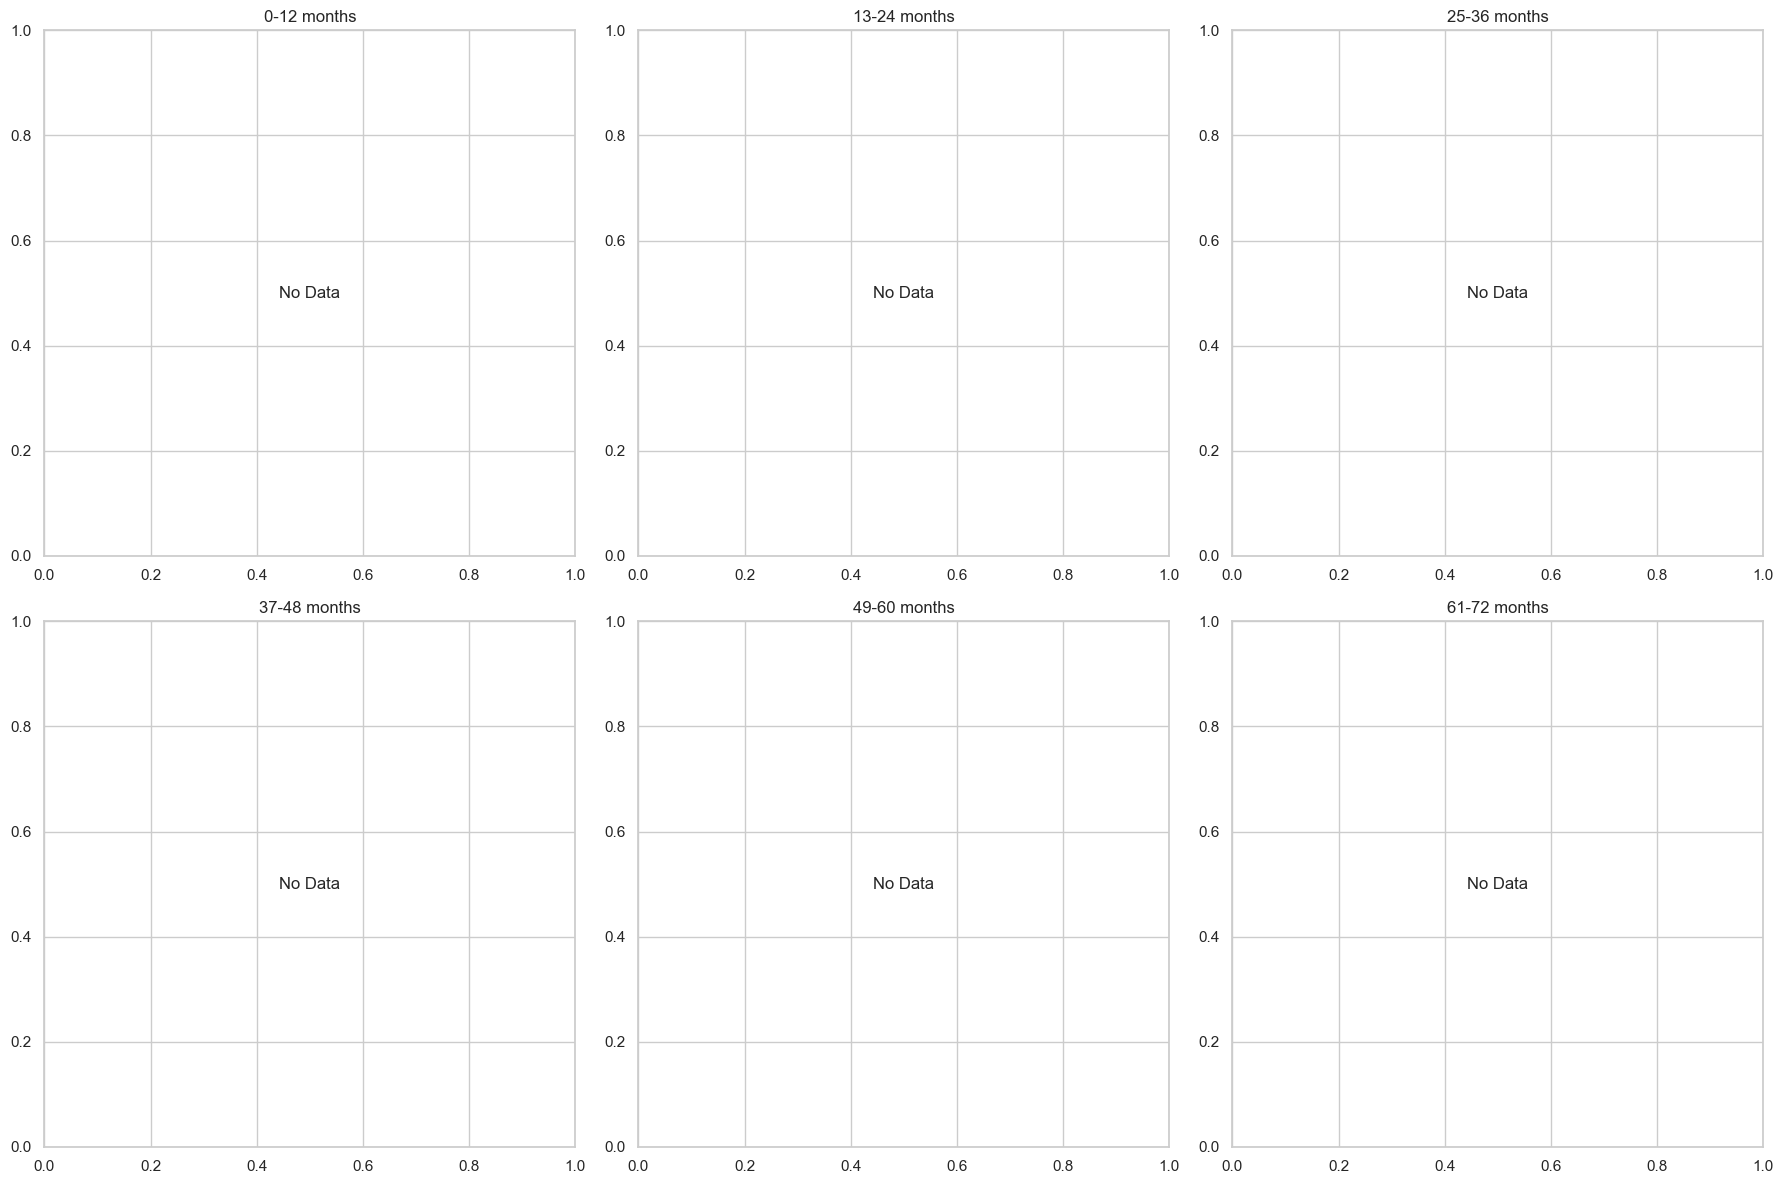

In [59]:
# 3.1 Plotting percentage of churned vs. non-churned customers by major tenure segments with percentages
plt.figure(figsize=(18, 12))
tenure_labels = ['0-12 months', '13-24 months', '25-36 months', '37-48 months', '49-60 months', '61-72 months']
tenure_groups = ['0-12', '13-24', '25-36', '37-48', '49-60', '61-72']
for i, group in enumerate(tenure_groups):
    plt.subplot(2, 3, i + 1)
    group_data = churn_data[churn_data['TenureGroup'] == group]['Churn'].value_counts(normalize=True) * 100
    if len(group_data) == 2:
        group_labels = group_data.index.tolist()
        plt.pie(group_data, labels=group_labels, autopct='%1.1f%%', startangle=140, colors=['#89CFF0', '#1F456E'], wedgeprops={'edgecolor': 'black'})
    elif len(group_data) == 1:
        group_labels = group_data.index.tolist()
        plt.pie(group_data, labels=group_labels, autopct='%1.1f%%', startangle=140, colors=['#89CFF0' if group_labels[0] == 'No' else '#1F456E'], wedgeprops={'edgecolor': 'black'})
    else:
        plt.text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center', fontsize=12)
    plt.title(tenure_labels[i])
plt.tight_layout()
plt.show()

        CustomerID Gender  SeniorCitizen Partner Dependents      Tenure  \
count          578    578     578.000000     578        578  578.000000   
unique         578      2            NaN       2          2         NaN   
top     9305-CDSKC   Male            NaN      No         No         NaN   
freq             1    300            NaN     305        480         NaN   
mean           NaN    NaN       0.314879     NaN        NaN   30.487889   
std            NaN    NaN       0.464870     NaN        NaN   21.834830   
min            NaN    NaN       0.000000     NaN        NaN    1.000000   
25%            NaN    NaN       0.000000     NaN        NaN   11.000000   
50%            NaN    NaN       0.000000     NaN        NaN   27.000000   
75%            NaN    NaN       1.000000     NaN        NaN   49.000000   
max            NaN    NaN       1.000000     NaN        NaN   72.000000   

       PhoneService MultipleLines InternetService OnlineSecurity  ...  \
count           578       

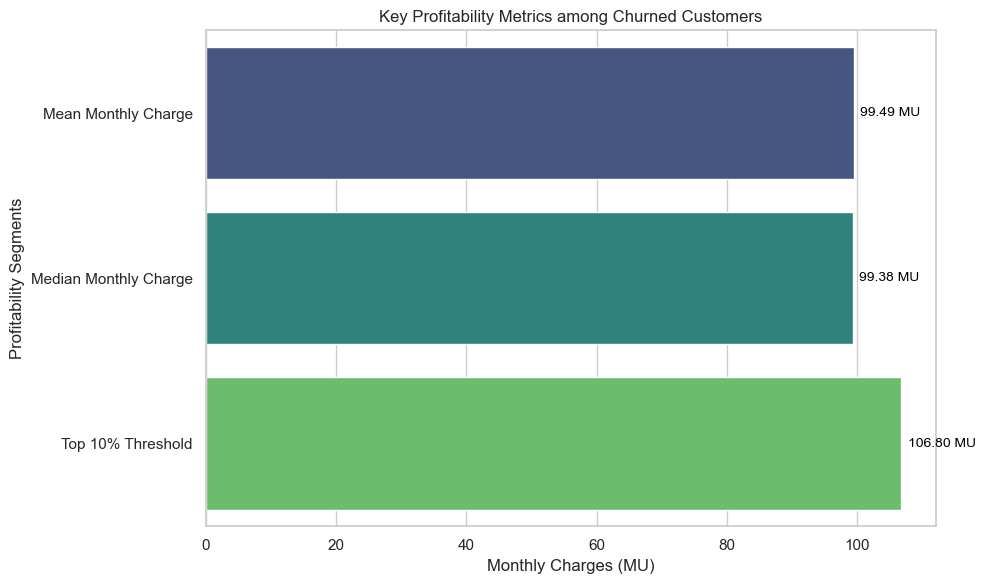

In [60]:
# Define profitability as high monthly charges
high_value_customers = churn_data[churn_data['MonthlyCharges'] > churn_data['MonthlyCharges'].quantile(0.75)]
churned_high_value_customers = high_value_customers[high_value_customers['Churn'] == 'Yes']

# Display summary statistics of churned high-value customers
patterns = churned_high_value_customers.describe(include='all')
print(patterns)

# Plotting key profitability metrics among churned customers
fig, ax = plt.subplots(figsize=(10, 6))
metrics = ['Mean Monthly Charge', 'Median Monthly Charge', 'Top 10% Threshold']
values = [
    churned_high_value_customers['MonthlyCharges'].mean(),
    churned_high_value_customers['MonthlyCharges'].median(),
    churned_high_value_customers['MonthlyCharges'].quantile(0.9)
]
sns.barplot(y=metrics, x=values, palette='viridis', ax=ax)
ax.set_title('Key Profitability Metrics among Churned Customers')
ax.set_xlabel('Monthly Charges (MU)')
ax.set_ylabel('Profitability Segments')
for i, v in enumerate(values):
    ax.text(v + 1, i, f'{v:.2f} MU', color='black', va='center', fontsize=10)
plt.tight_layout()
plt.show()

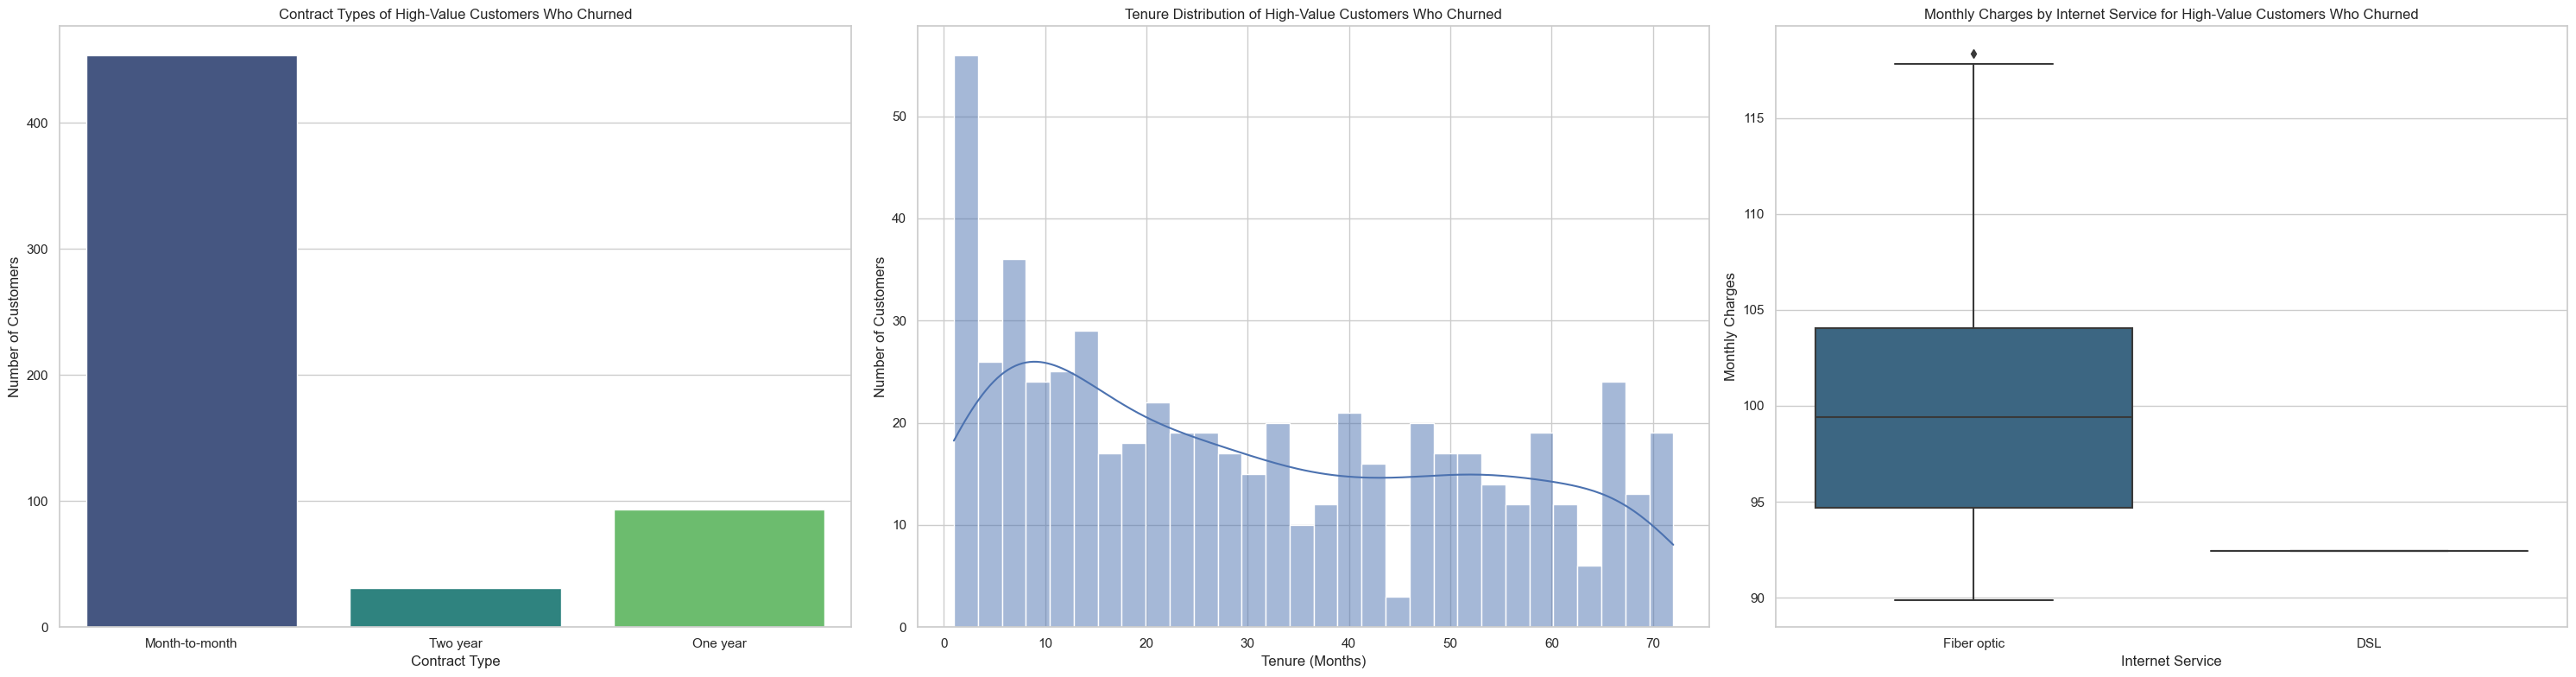

        CustomerID Gender  SeniorCitizen Partner Dependents      Tenure  \
count          578    578     578.000000     578        578  578.000000   
unique         578      2            NaN       2          2         NaN   
top     9305-CDSKC   Male            NaN      No         No         NaN   
freq             1    300            NaN     305        480         NaN   
mean           NaN    NaN       0.314879     NaN        NaN   30.487889   
std            NaN    NaN       0.464870     NaN        NaN   21.834830   
min            NaN    NaN       0.000000     NaN        NaN    1.000000   
25%            NaN    NaN       0.000000     NaN        NaN   11.000000   
50%            NaN    NaN       0.000000     NaN        NaN   27.000000   
75%            NaN    NaN       1.000000     NaN        NaN   49.000000   
max            NaN    NaN       1.000000     NaN        NaN   72.000000   

       PhoneService MultipleLines InternetService OnlineSecurity  ...  \
count           578       

In [61]:
#3.Identify patterns among the most profitable customers who have churned
# Define profitability as high monthly charges
high_value_customers = churn_data[churn_data['MonthlyCharges'] > churn_data['MonthlyCharges'].quantile(0.75)]
churned_high_value_customers = high_value_customers[high_value_customers['Churn'] == 'Yes']
# Plotting graphs to observe patterns among the most profitable customers who have churned in one figure
fig, axes = plt.subplots(1, 3, figsize=(30, 8))

# Plot 1: Contract Types of High-Value Customers Who Churned
sns.countplot(data=churned_high_value_customers, x='Contract', palette='viridis', ax=axes[0])
axes[0].set_title('Contract Types of High-Value Customers Who Churned')
axes[0].set_xlabel('Contract Type')
axes[0].set_ylabel('Number of Customers')

# Plot 2: Tenure Distribution of High-Value Customers Who Churned
sns.histplot(data=churned_high_value_customers, x='Tenure', kde=True, bins=30, palette='viridis', ax=axes[1])
axes[1].set_title('Tenure Distribution of High-Value Customers Who Churned')
axes[1].set_xlabel('Tenure (Months)')
axes[1].set_ylabel('Number of Customers')

# Plot 3: Monthly Charges by Internet Service for High-Value Customers Who Churned
sns.boxplot(data=churned_high_value_customers, x='InternetService', y='MonthlyCharges', palette='viridis', ax=axes[2])
axes[2].set_title('Monthly Charges by Internet Service for High-Value Customers Who Churned')
axes[2].set_xlabel('Internet Service')
axes[2].set_ylabel('Monthly Charges')

plt.tight_layout()
plt.show()
patterns = churned_high_value_customers.describe(include='all')
print(patterns)


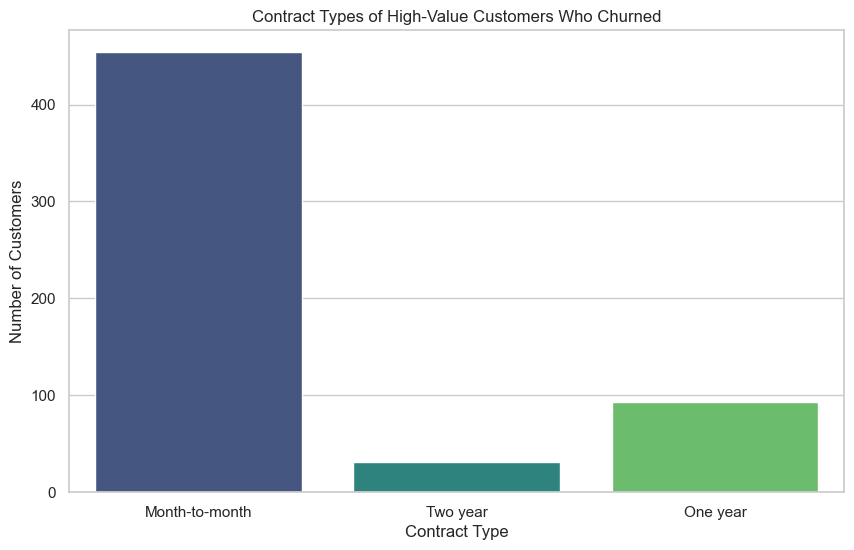

In [62]:
# Plotting graphs to observe patterns among the most profitable customers who have churned
plt.figure(figsize=(10, 6))
sns.countplot(data=churned_high_value_customers, x='Contract', palette='viridis')
plt.title('Contract Types of High-Value Customers Who Churned')
plt.xlabel('Contract Type')
plt.ylabel('Number of Customers')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data=churned_high_value_customers, x='Tenure', kde=True, bins=30, palette='viridis')
plt.title('Tenure Distribution of High-Value Customers Who Churned')
plt.xlabel('Tenure (Months)')
plt.ylabel('Number of Customers')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=churned_high_value_customers, x='InternetService', y='MonthlyCharges', palette='viridis')
plt.title('Monthly Charges by Internet Service for High-Value Customers Who Churned')
plt.xlabel('Internet Service')
plt.ylabel('Monthly Charges')
plt.show()

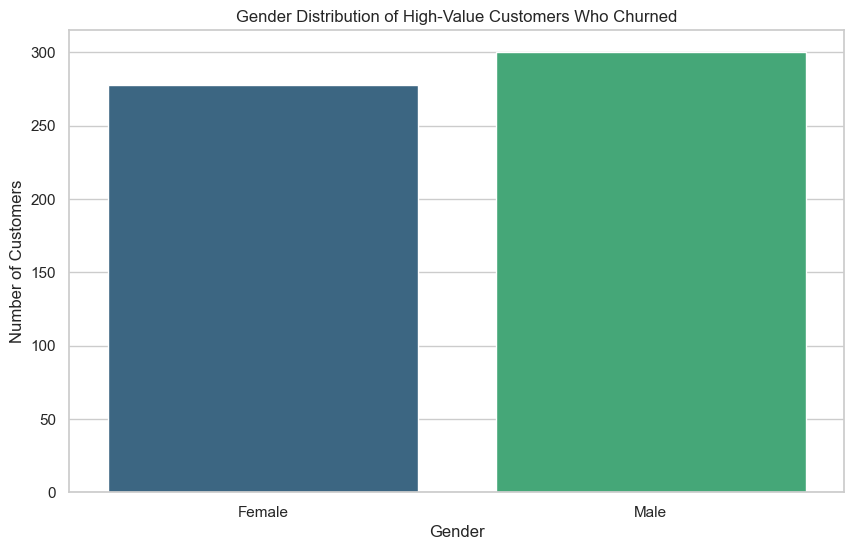

In [63]:
# Plotting patterns for Gender, SeniorCitizen, Partner, and Dependents , PaperlessBilling among high-value customers who churned
plt.figure(figsize=(10, 6))
sns.countplot(data=churned_high_value_customers, x='Gender', palette='viridis')
plt.title('Gender Distribution of High-Value Customers Who Churned')
plt.xlabel('Gender')
plt.ylabel('Number of Customers')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=churned_high_value_customers, x='SeniorCitizen', palette='viridis')
plt.title('Senior Citizen Status of High-Value Customers Who Churned')
plt.xlabel('Senior Citizen')
plt.ylabel('Number of Customers')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=churned_high_value_customers, x='Partner', palette='viridis')
plt.title('Partner Status of High-Value Customers Who Churned')
plt.xlabel('Partner')
plt.ylabel('Number of Customers')
plt.show()


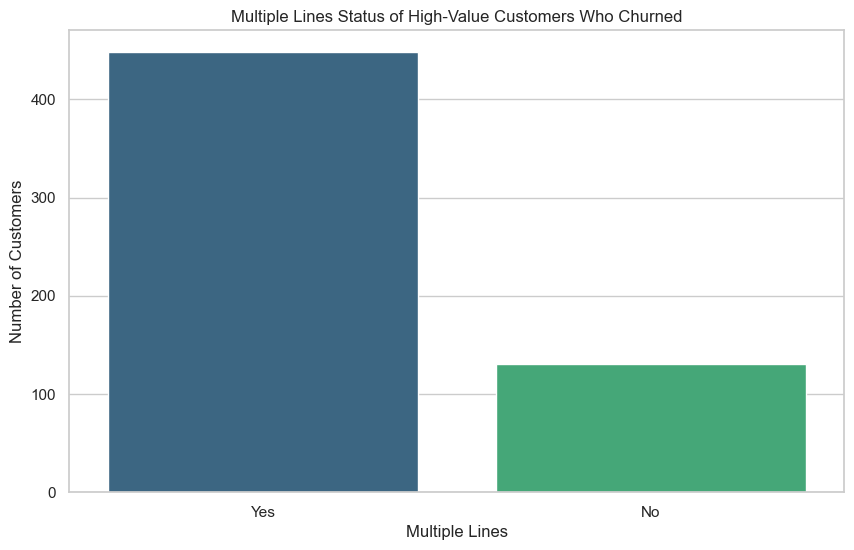

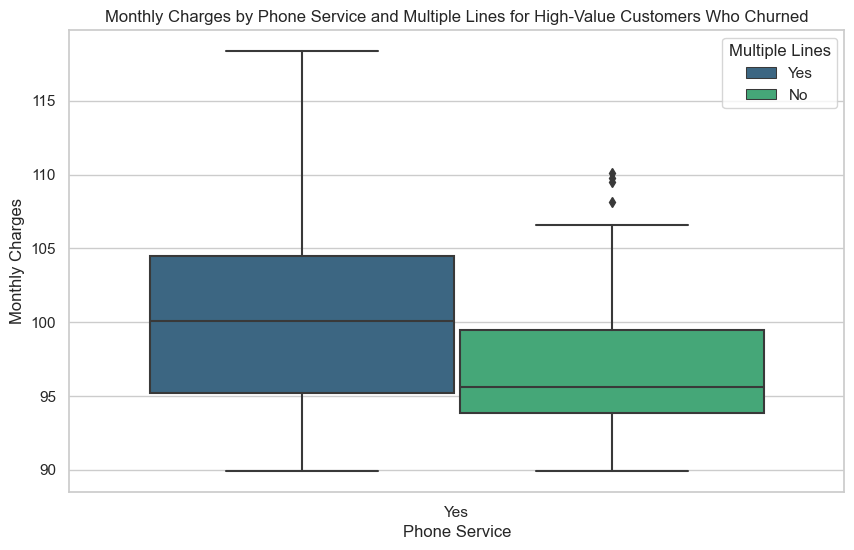

In [64]:
# Plotting patterns for PhoneService and MultipleLines among high-value customers who churned
plt.figure(figsize=(10, 6))
sns.countplot(data=churned_high_value_customers, x='PhoneService', palette='viridis')
plt.title('Phone Service Status of High-Value Customers Who Churned')
plt.xlabel('Phone Service')
plt.ylabel('Number of Customers')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=churned_high_value_customers, x='MultipleLines', palette='viridis')
plt.title('Multiple Lines Status of High-Value Customers Who Churned')
plt.xlabel('Multiple Lines')
plt.ylabel('Number of Customers')
plt.show()

# Pie chart for MultipleLines
plt.figure(figsize=(8, 8))
multiple_lines_counts = churned_high_value_customers['MultipleLines'].value_counts()
plt.pie(multiple_lines_counts, labels=multiple_lines_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis'))
plt.title('Multiple Lines Status of High-Value Customers Who Churned')
plt.show()

# Additional visualization: Relationship between PhoneService, MultipleLines, and Monthly Charges
plt.figure(figsize=(10, 6))
sns.boxplot(data=churned_high_value_customers, x='PhoneService', y='MonthlyCharges', hue='MultipleLines', palette='viridis')
plt.title('Monthly Charges by Phone Service and Multiple Lines for High-Value Customers Who Churned')
plt.xlabel('Phone Service')
plt.ylabel('Monthly Charges')
plt.legend(title='Multiple Lines')
plt.show()



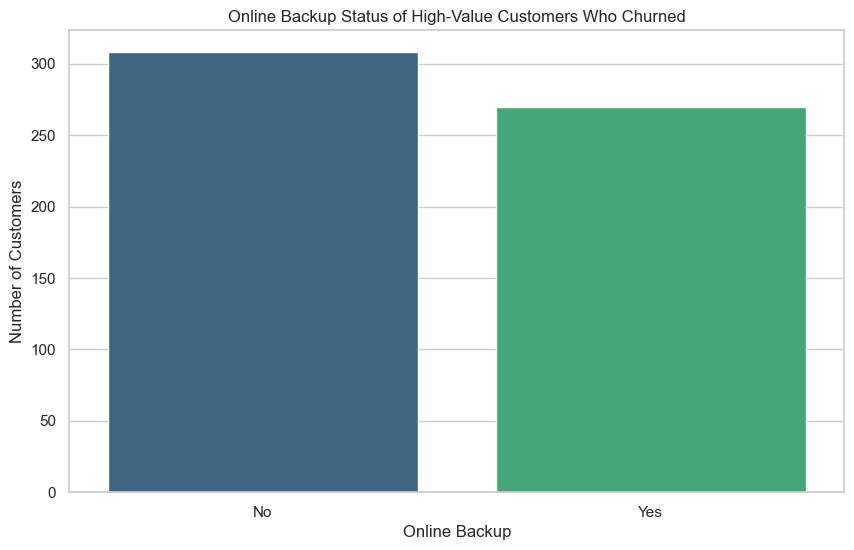

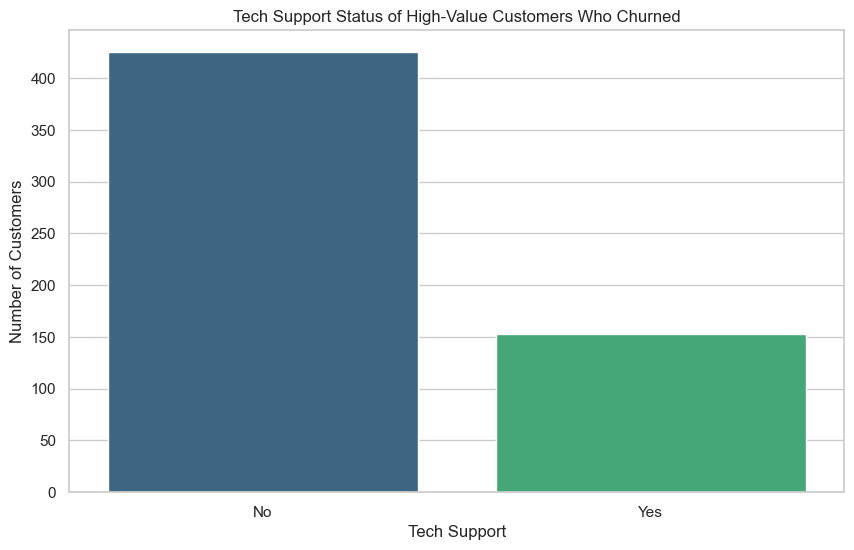

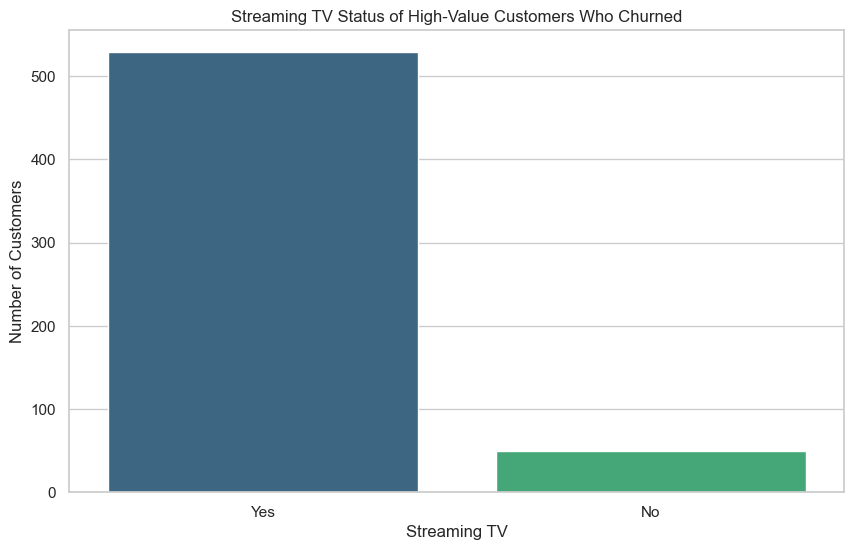

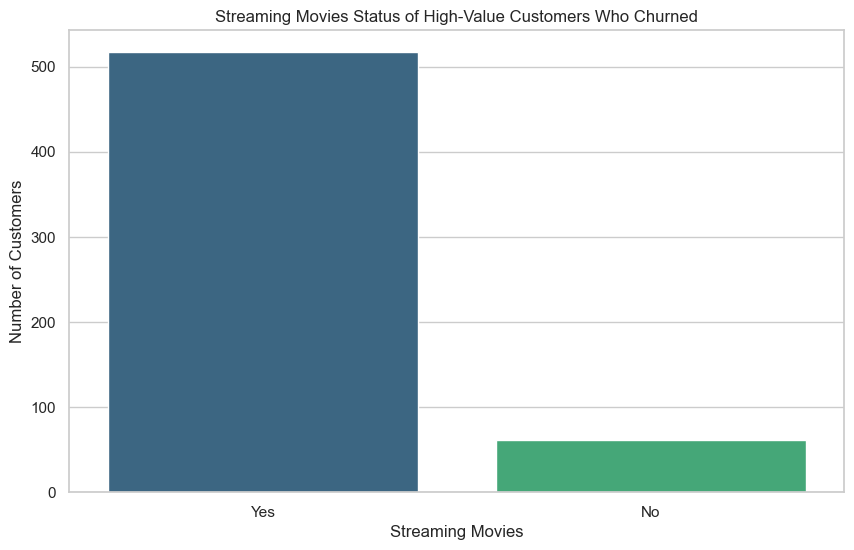

In [65]:
# Plotting patterns for OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, and StreamingMovies among high-value customers who churned
plt.figure(figsize=(10, 6))
sns.countplot(data=churned_high_value_customers, x='OnlineSecurity', palette='viridis')
plt.title('Online Security Status of High-Value Customers Who Churned')
plt.xlabel('Online Security')
plt.ylabel('Number of Customers')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=churned_high_value_customers, x='OnlineBackup', palette='viridis')
plt.title('Online Backup Status of High-Value Customers Who Churned')
plt.xlabel('Online Backup')
plt.ylabel('Number of Customers')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=churned_high_value_customers, x='DeviceProtection', palette='viridis')
plt.title('Device Protection Status of High-Value Customers Who Churned')
plt.xlabel('Device Protection')
plt.ylabel('Number of Customers')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=churned_high_value_customers, x='TechSupport', palette='viridis')
plt.title('Tech Support Status of High-Value Customers Who Churned')
plt.xlabel('Tech Support')
plt.ylabel('Number of Customers')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=churned_high_value_customers, x='StreamingTV', palette='viridis')
plt.title('Streaming TV Status of High-Value Customers Who Churned')
plt.xlabel('Streaming TV')
plt.ylabel('Number of Customers')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=churned_high_value_customers, x='StreamingMovies', palette='viridis')
plt.title('Streaming Movies Status of High-Value Customers Who Churned')
plt.xlabel('Streaming Movies')
plt.ylabel('Number of Customers')
plt.show()


In [66]:
# Plotting all patterns for OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, and StreamingMovies in one graph
plt.figure(figsize=(12, 8))
sns.countplot(data=churned_high_value_customers.melt(value_vars=['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']), 
              x='variable', hue='value', palette='viridis')
plt.title('Service Status of High-Value Customers Who Churned')
plt.xlabel('Service Type')
plt.ylabel('Number of Customers')
plt.legend(title='Status', labels=['No', 'Yes'])
plt.show()

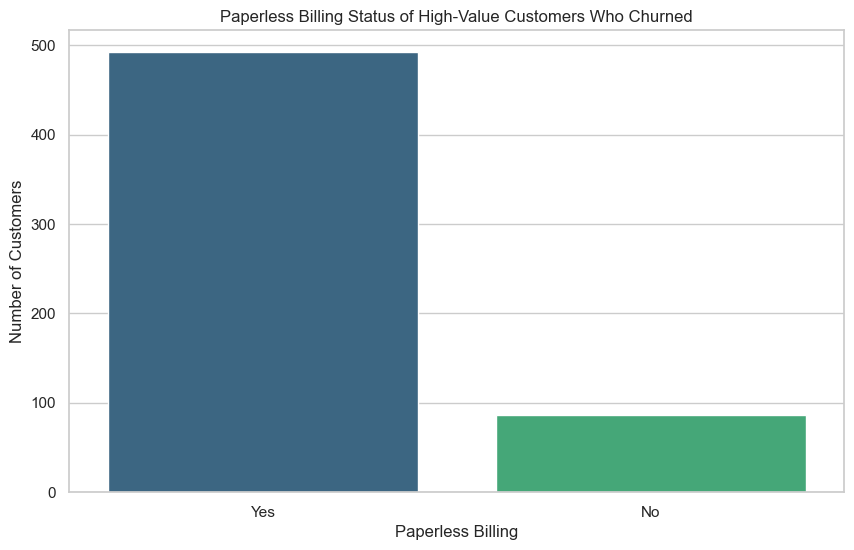

In [67]:
# Plotting patterns for PaperlessBilling and PaymentMethod among high-value customers who churned
plt.figure(figsize=(10, 6))
sns.countplot(data=churned_high_value_customers, x='PaperlessBilling', palette='viridis')
plt.title('Paperless Billing Status of High-Value Customers Who Churned')
plt.xlabel('Paperless Billing')
plt.ylabel('Number of Customers')
plt.show()

# Donut chart for PaperlessBilling
plt.figure(figsize=(8, 8))
paperless_billing_counts = churned_high_value_customers['PaperlessBilling'].value_counts()
plt.pie(paperless_billing_counts, labels=paperless_billing_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis'), wedgeprops={'width':0.3})
plt.title('Paperless Billing Status of High-Value Customers Who Churned')
plt.show()

plt.figure(figsize=(12, 8))
sns.countplot(data=churned_high_value_customers, x='PaymentMethod', palette='viridis')
plt.title('Payment Method Distribution of High-Value Customers Who Churned')
plt.xlabel('Payment Method')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

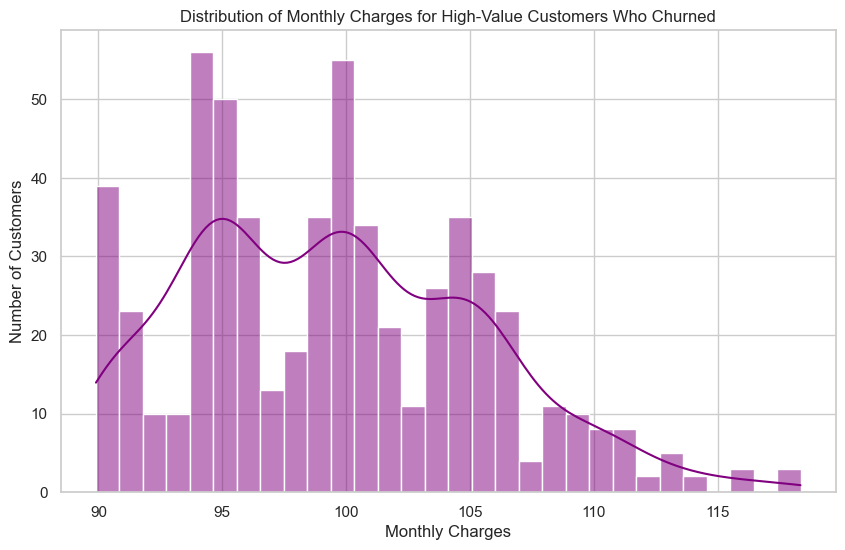

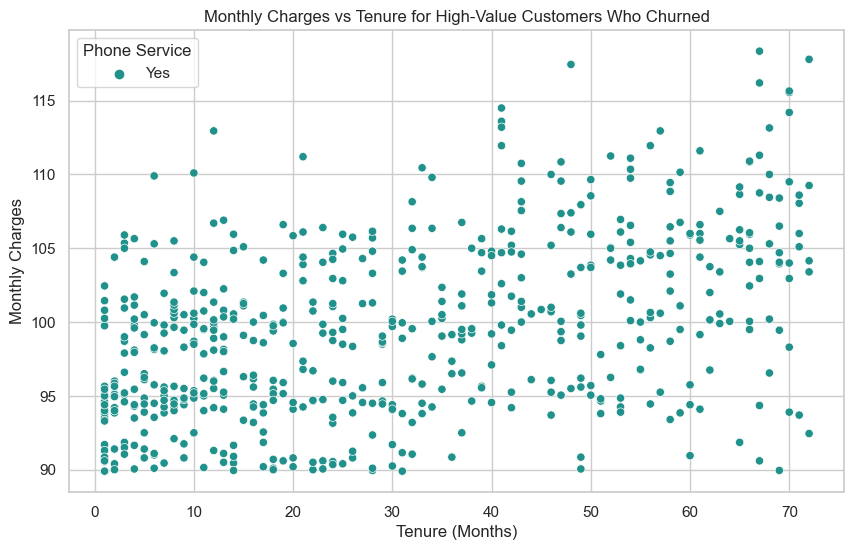

In [68]:
# Plotting the distribution of MonthlyCharges among high-value customers who have churned
plt.figure(figsize=(10, 6))
sns.histplot(data=churned_high_value_customers, x='MonthlyCharges', kde=True, bins=30, color='purple')
plt.title('Distribution of Monthly Charges for High-Value Customers Who Churned')
plt.xlabel('Monthly Charges')
plt.ylabel('Number of Customers')
plt.show()

# Scatter plot for MonthlyCharges vs Tenure among high-value customers who have churned
plt.figure(figsize=(10, 6))
sns.scatterplot(data=churned_high_value_customers, x='Tenure', y='MonthlyCharges', hue='PhoneService', palette='viridis')
plt.title('Monthly Charges vs Tenure for High-Value Customers Who Churned')
plt.xlabel('Tenure (Months)')
plt.ylabel('Monthly Charges')
plt.legend(title='Phone Service')
plt.show()


In [69]:
#4. Determine the main **drivers of churn** quantitatively of random forest
# Preprocessing the data
churn_data['TotalCharges'] = pd.to_numeric(churn_data['TotalCharges'], errors='coerce')
churn_data.fillna(churn_data.select_dtypes(include=np.number).mean(), inplace=True)

# Encoding categorical variables
churn_data_encoded = pd.get_dummies(churn_data, drop_first=True)

# Splitting data into features and target variable
X = churn_data_encoded.drop('Churn_Yes', axis=1)
y = churn_data_encoded['Churn_Yes']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Training a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predicting on the test set
y_pred = rf_model.predict(X_test)

# Evaluating the model
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('\nClassification Report:')
print(classification_report(y_test, y_pred))
print('\nAccuracy Score:', accuracy_score(y_test, y_pred))


Confusion Matrix:
[[1422  117]
 [ 308  266]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1539
           1       0.69      0.46      0.56       574

    accuracy                           0.80      2113
   macro avg       0.76      0.69      0.71      2113
weighted avg       0.79      0.80      0.78      2113


Accuracy Score: 0.7988641741599621


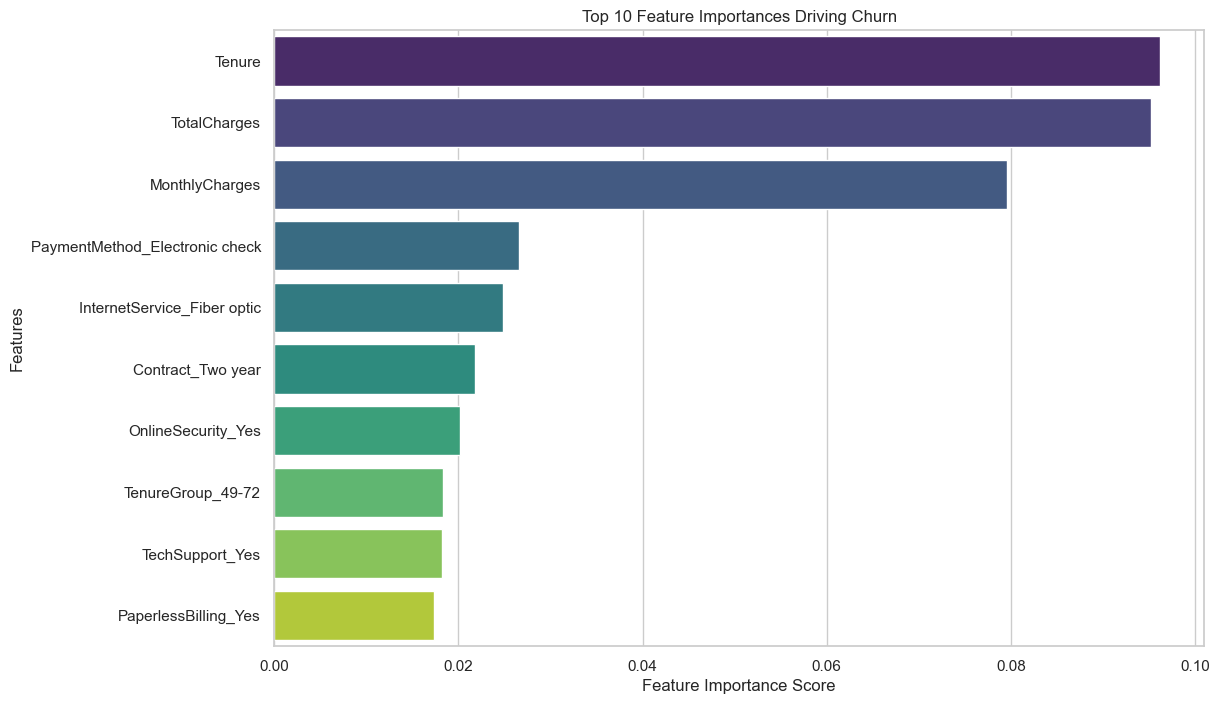

In [70]:
# Determining feature importance
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

# Plotting feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances[:10], y=feature_importances.index[:10], palette='viridis')
plt.title('Top 10 Feature Importances Driving Churn')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.show()

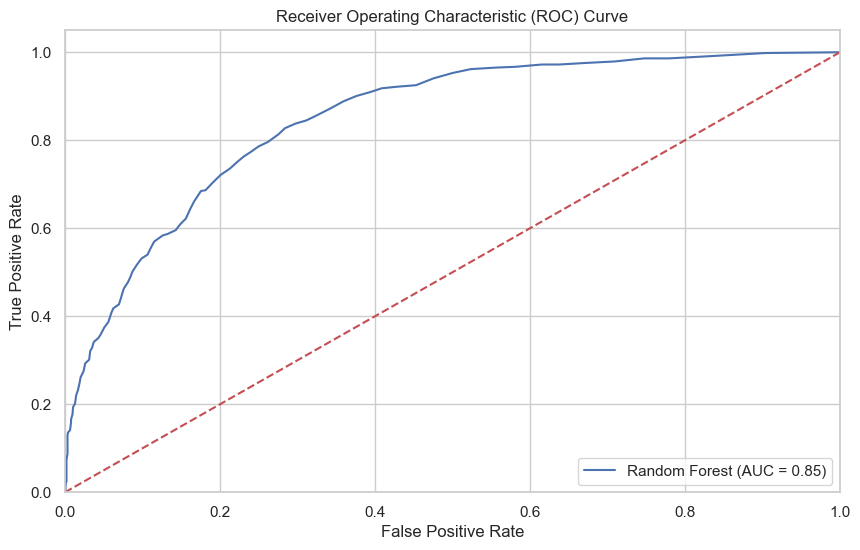

In [71]:
# ROC Curve and AUC for Random Forest
rf_roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

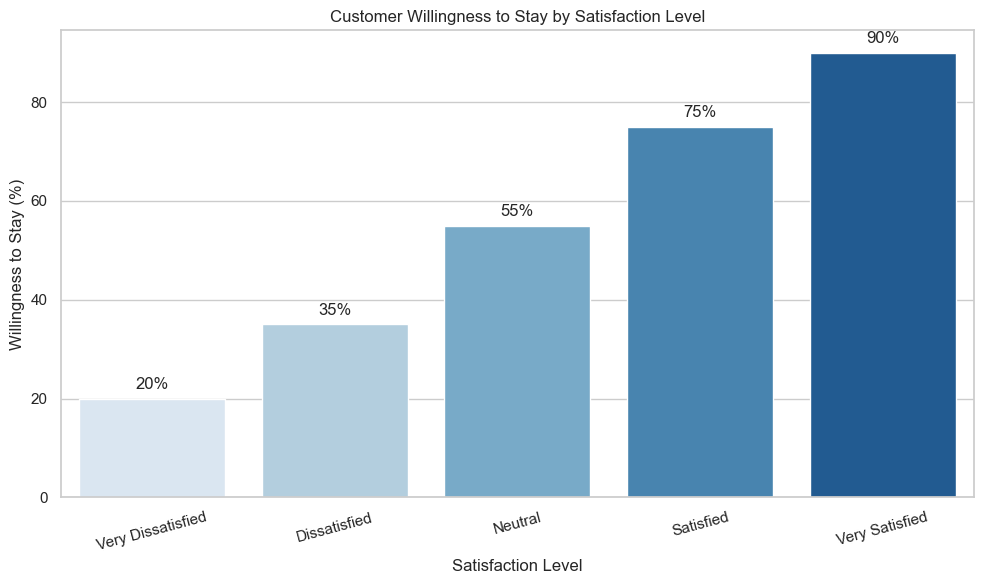

In [72]:
#Customer Willingness to Stay by Satisfaction Level
satisfaction_levels = ['Very Dissatisfied', 'Dissatisfied', 'Neutral', 'Satisfied', 'Very Satisfied']
willingness_to_stay = [20, 35, 55, 75, 90]

plt.figure(figsize=(10, 6))
sns.barplot(x=satisfaction_levels, y=willingness_to_stay, palette='Blues')
plt.title('Customer Willingness to Stay by Satisfaction Level')
plt.xlabel('Satisfaction Level')
plt.ylabel('Willingness to Stay (%)')
for i, v in enumerate(willingness_to_stay):
    plt.text(i, v + 2, f'{v}%', ha='center', fontsize=12)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

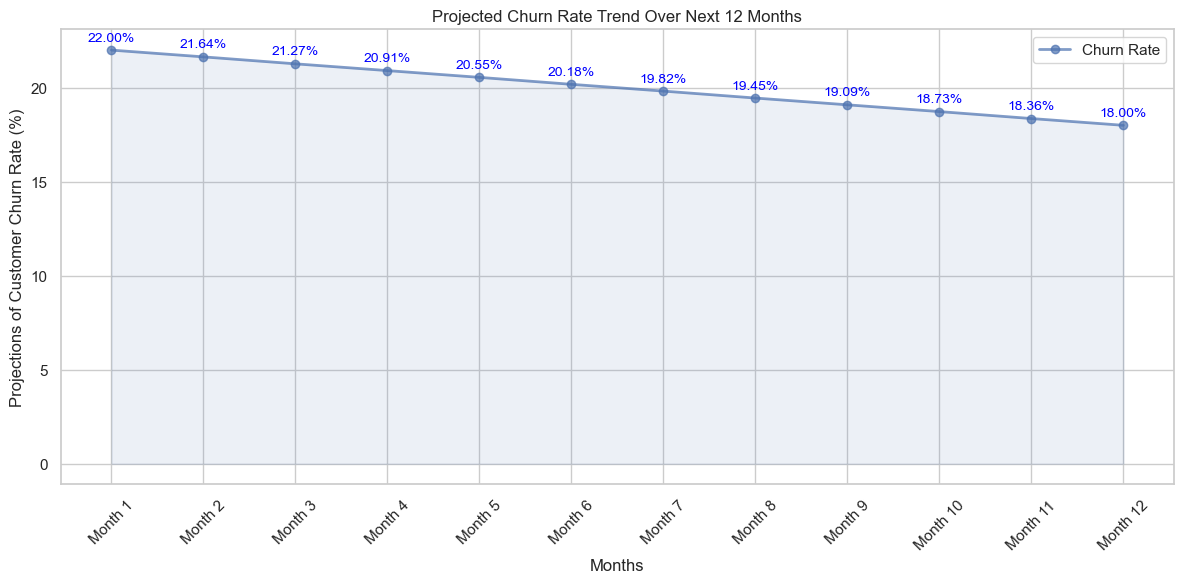

In [73]:
#Projected Churn Rate Trend Over Next 12 Months
months = ['Month 1', 'Month 2', 'Month 3', 'Month 4', 'Month 5', 'Month 6', 'Month 7', 'Month 8', 'Month 9', 'Month 10', 'Month 11', 'Month 12']
churn_rate = [22.00, 21.64, 21.27, 20.91, 20.55, 20.18, 19.82, 19.45, 19.09, 18.73, 18.36, 18.00]

plt.figure(figsize=(12, 6))
plt.plot(months, churn_rate, marker='o', linestyle='-', color='b', linewidth=2, alpha=0.7, label='Churn Rate')
plt.fill_between(months, churn_rate, color='b', alpha=0.1)
plt.title('Projected Churn Rate Trend Over Next 12 Months')
plt.xlabel('Months')
plt.ylabel('Projections of Customer Churn Rate (%)')
for i, v in enumerate(churn_rate):
    plt.text(i, v + 0.5, f'{v:.2f}%', ha='center', fontsize=10, color='blue')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [74]:
# Recommendations for senior management to limit customer churn
recommendations = [
    "1. Implement personalized retention strategies for high-risk customers identified by the model, such as offering discounts or better plans.",
    "2. Focus on improving customer experience for customers with short tenure by providing onboarding assistance and additional support.",
    "3. Encourage long-term contracts to reduce churn by offering discounts or other incentives for contract renewals.",
    "4. Improve services like OnlineSecurity, TechSupport, and DeviceProtection that show a high correlation with churn.",
    "5. Reduce price sensitivity by providing bundled services that include high-value features at a reasonable price.",
    "6. Monitor customer feedback closely, especially among those using month-to-month contracts, to address concerns early.",
    "7. Enhance customer engagement through proactive communication, targeted offers, and loyalty programs to increase satisfaction and retention."
]

for rec in recommendations:
    print(rec)

1. Implement personalized retention strategies for high-risk customers identified by the model, such as offering discounts or better plans.
2. Focus on improving customer experience for customers with short tenure by providing onboarding assistance and additional support.
3. Encourage long-term contracts to reduce churn by offering discounts or other incentives for contract renewals.
4. Improve services like OnlineSecurity, TechSupport, and DeviceProtection that show a high correlation with churn.
5. Reduce price sensitivity by providing bundled services that include high-value features at a reasonable price.
6. Monitor customer feedback closely, especially among those using month-to-month contracts, to address concerns early.
7. Enhance customer engagement through proactive communication, targeted offers, and loyalty programs to increase satisfaction and retention.


In [75]:
# load test data and output churn probabilities
# Load test dataset (same format as provided data, but without labels)
test_data_path = 'D:/PWC-DS/client_data/Churn.csv' 
test_data = pd.read_csv(test_data_path)

In [83]:
# Preprocessing test data - Ensure the same preprocessing steps as training data
import sklearn
customer_ids = test_data['CustomerID']  # Preserve customer IDs before encoding
test_data['TotalCharges'] = pd.to_numeric(test_data['TotalCharges'], errors='coerce')
test_data.fillna(test_data.select_dtypes(include=np.number).mean(), inplace=True)
test_data_encoded = pd.get_dummies(test_data, drop_first=True)

# Align test data with training data columns
test_data_encoded = test_data_encoded.reindex(columns=X.columns, fill_value=0)

# Scaling features
X_test_scaled = sklearn.preprocessing.StandardScaler().fit_transform(test_data_encoded)

# Predicting churn probabilities for each client
churn_probabilities = rf_model.predict_proba(X_test_scaled)[:, 1]

# Output churn probabilities
test_data['customerID'] = customer_ids  # Add customer IDs back to the DataFrame
test_data['Churn_Probability'] = churn_probabilities
print(test_data[['customerID', 'Churn_Probability']])

# Save the output to a CSV file
test_data[['customerID', 'Churn_Probability']].to_csv('D:/PWC-DS/client_data/Churn_Probabilities_Output.csv', index=False)

D:\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


      customerID  Churn_Probability
0     7590-VHVEG               0.35
1     5575-GNVDE               0.21
2     3668-QPYBK               0.63
3     7795-CFOCW               0.21
4     9237-HQITU               0.80
...          ...                ...
7038  6840-RESVB               0.28
7039  2234-XADUH               0.33
7040  4801-JZAZL               0.37
7041  8361-LTMKD               0.78
7042  3186-AJIEK               0.36

[7043 rows x 2 columns]
